
# *Exploration of Taxi Trip Fares in the San Francisco Bay Area*

In [4]:
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [63]:
taxi_data = Table.read_table("SF_taxi_data.csv")
taxi_data = taxi_data.where("num", 1).where("fare ($)", are.above_or_equal_to(3.5))
taxi_data

id,departure time,arrival time,fare ($),num,dep lon,dep lat,arr lon,arr lat,deptaz,arrtaz,dist (miles)
0,9/1/12 0:11,9/1/12 0:20,13.2,1,-122.414,37.8027,-122.421,37.7854,38,30,1.98084
1,9/1/12 0:23,9/1/12 0:31,10.65,1,-122.42,37.7861,-122.435,37.7622,30,94,2.40224
2,9/1/12 0:45,9/1/12 0:49,9,1,-122.415,37.7747,-122.408,37.7826,10,11,0.479348
4,9/1/12 1:09,9/1/12 1:13,7.35,1,-122.43,37.7978,-122.418,37.789,45,32,1.03807
5,9/1/12 1:40,9/1/12 1:52,11.75,1,-122.433,37.7841,-122.411,37.787,77,7,0.960851
6,9/1/12 2:49,9/1/12 2:51,5.15,1,-122.409,37.7856,-122.412,37.791,7,29,0.414315
7,9/1/12 3:29,9/1/12 3:47,43.65,1,-122.403,37.7927,-122.386,37.6181,2,239,14.5105
8,9/1/12 0:33,9/1/12 0:57,46.75,1,-122.387,37.6174,-122.407,37.7889,239,5,14.2747
9,9/1/12 4:39,9/1/12 4:43,6.25,1,-122.422,37.7977,-122.418,37.789,34,31,0.685312
10,9/1/12 1:59,9/1/12 2:05,9.55,1,-122.418,37.791,-122.429,37.7724,32,81,1.59807


### Relationship Between Fares and Distance

According to the SFMTA fare calculation table, <br>
$Fare(x) \geq 3.5 + 0.55 × (5x − 1)$ <br>
We will analyze how this model compares to the actual relationship between fares and distance using real data.

In [19]:
predicted_fare = 3.5 + 0.55 * (5 * taxi_data.column("dist (miles)") - 1)
actual_fare = taxi_data.column("fare ($)")
least_squared_error = sum((actual_fare - predicted_fare) ** 2) / len(actual_fare)
least_squared_error

50.884708962942547

Since the least squared error between the actual and predicted fares is significantly over 0, we can see that the model is not an accurate indicator of the actual relationship between fares and distance. We can try to analyze further by providing a graph.

In [21]:
X = np.vstack([taxi_data["dist (miles)"], np.ones(len(taxi_data["dist (miles)"]))]).T
y = taxi_data["fare ($)"]
theta = np.linalg.solve(X.T.dot(X), X.T.dot(y))

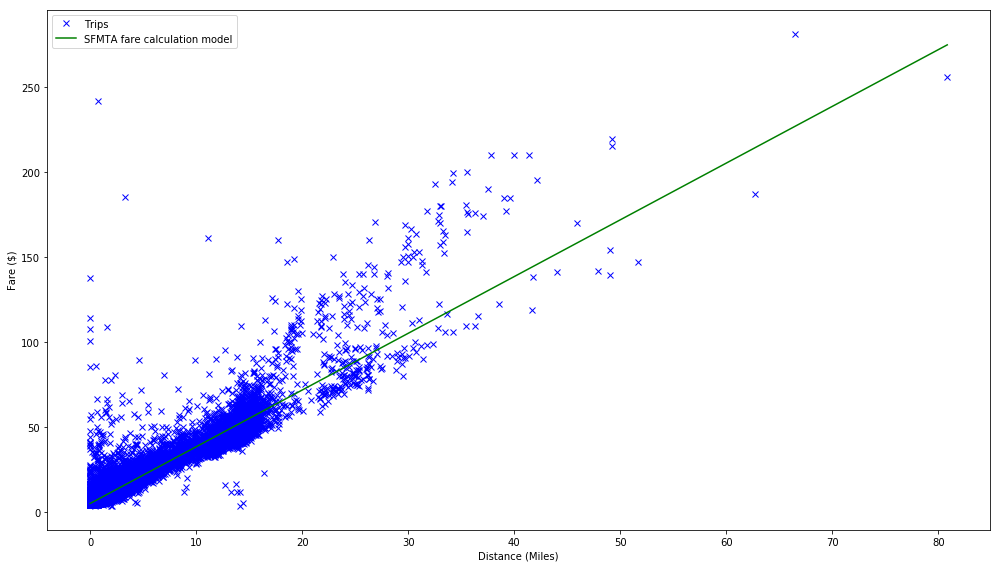

In [55]:
plt.figure(figsize=(14,8))
xlim = (min(taxi_data["dist (miles)"]), max(taxi_data["dist (miles)"]))
ylim = (min(taxi_data["fare ($)"]), max(taxi_data["fare ($)"]))
plt.plot(taxi_data["dist (miles)"], taxi_data["fare ($)"], 'bx')
plt.plot(xlim, [theta[0]*xlim[0]+theta[1], theta[0]*xlim[1]+theta[1]], 'g-')
plt.legend(["Trips", "SFMTA fare calculation model"], loc="upper left")
plt.xlabel("Distance (Miles)")
plt.ylabel("Fare ($)")
plt.tight_layout()

### Analysis of Trips Related to SFO

In order to split up the total taxi trips to trips that include SFO and trips that do not include SFO, let us divide the taxi_data table into two tables that fit the criteria.

In [4]:
sfo_taz = taxi_data.group("deptaz").sort("count", descending=True).column("deptaz").item(0)
sfo_labeled_table = taxi_data.with_column("sfo", np.logical_or(taxi_data.column("deptaz") == np.full(taxi_data.num_rows, sfo_taz), taxi_data.column("arrtaz") == np.full(taxi_data.num_rows, sfo_taz)))
sfo_trips = sfo_labeled_table.where("sfo", True).drop("sfo")
no_sfo_trips = sfo_labeled_table.where("sfo", False).drop("sfo")

Let us analyze the differences between trips that include SFO and trips that do not by looking at the distances and fares.

In [5]:
print("Mean distance for sfo trips : ", np.mean(sfo_trips.column("dist (miles)")))
print("Mean distance for non-sfo trips : ", np.mean(no_sfo_trips.column("dist (miles)")))
print("Mean fare for sfo trips : ", np.mean(sfo_trips.column("fare ($)")))
print("Mean fare for non-sfo trips : ", np.mean(no_sfo_trips.column("fare ($)")))

Mean distance for sfo trips :  13.6399973334
Mean distance for non-sfo trips :  2.14582874527
Mean fare for sfo trips :  49.0883790447
Mean fare for non-sfo trips :  12.3978968537


From these means, we can see that the distances for trips including SFO are on average much bigger than other trips, hence the average fare is also higher. This logically makes sense because SFO is quite far from most hotspots in the Bay Area.

### Linear Regression of Travel Distance vs. Extra Cost

In [6]:
# Analysis here

### Linear Regression of Travel Duration vs. Extra Cost

In [7]:
# Analysis here

### Linear Regression vs. K-Nearest Neighbors

In [64]:
from datetime import datetime
def getDatetimeObj(dateStr, fmt):
    """
    Convert string in date format to datatime object
    """
    try:
        t = datetime.strptime(dateStr, fmt)
    except ValueError as v:
        if len(v.args) > 0 and v.args[0].startswith('unconverted data remains: '):
            dateStr = dateStr[:-(len(v.args[0]) - 26)]
            t = datetime.strptime(dateStr, fmt)
        else:
            raise
    return t

taxi_data["departure time"] = taxi_data.select("departure time").apply(lambda x: getDatetimeObj(x[0],"%m/%d/%y"))

First we will split our data into days 1-10 and days 11-17 using their departure time.

In [65]:
taxi_data_train = taxi_data.where(list(map(lambda x: x.day >= 1 
                                                          and x.day <= 10, 
                                                          taxi_data["departure time"])))
taxi_data_test = taxi_data.where(list(map(lambda x: x.day >= 11 and x.day <= 17 , 
                                                                taxi_data["departure time"])))

Now we will use linear regression to identify the fares in the testing data given the distances.

In [66]:
X = np.vstack([taxi_data_train["dist (miles)"], np.ones(len(taxi_data_train.column(0)))]).T
y = taxi_data_train["fare ($)"]
theta = np.linalg.solve(X.T.dot(X), X.T.dot(y))
print("Coefficients obtained by Linear Algebra: ",theta)

Coefficients obtained by Linear Algebra:  [ 3.31272061  5.0997545 ]


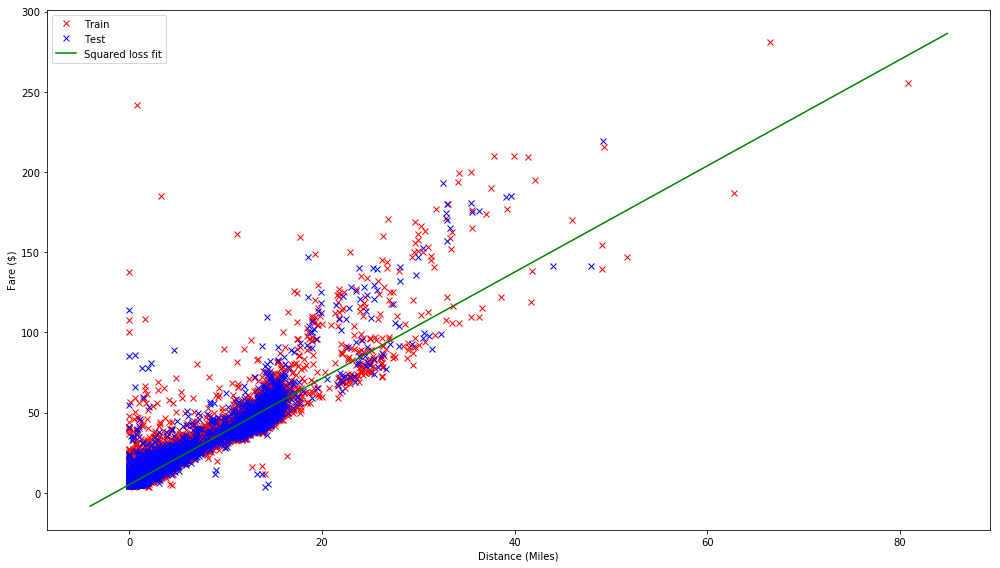

In [68]:
plt.figure(figsize=(14,8))
plt.plot(taxi_data_train["dist (miles)"], taxi_data_train["fare ($)"], 'rx')
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot(taxi_data_test["dist (miles)"], taxi_data_test["fare ($)"], 'bx')
plt.plot(xlim, [theta[0]*xlim[0]+theta[1], theta[0]*xlim[1]+theta[1]], 'g-')
plt.legend(["Train", "Test", "Squared loss fit"], loc="upper left")
plt.xlabel("Distance (Miles)")
plt.ylabel("Fare ($)")
plt.tight_layout()

In [69]:
#Least Squared Error
LSE = sum((taxi_data_test["fare ($)"]-(theta[0]*taxi_data_test["dist (miles)"]+theta[1]))**2)/taxi_data_test.num_rows
LSE

26.690733155169795

Now we will do the same analysis, except this time using k-NN using k={1,5,10}

In [ ]:
test2 = taxi_data_test.select(["dist (miles)","fare ($)"])

def distance(x, y):
    return np.sqrt(np.sum((x-y)**2,1))

def predict_load(input_table, to_predict, k, averaging=True):
    input_data = input_table.select('dist (miles)').values
    dists = distance(to_predict, input_data)
    inds = np.argsort(dists)[0:k]
    if averaging:
        most_common_response = np.mean(input_table['fare ($)'][inds])
    else:
        most_common_response = np.argmax(np.bincount(list(input_table['fare ($)'][inds])))    
    return most_common_response

test2['predicted_k1'] = test2.apply(lambda dist: predict_load(taxi_data_train, dist, 1, True),'dist (miles)')
test2['predicted_k5'] = test2.apply(lambda dist: predict_load(taxi_data_train, dist, 5, True),'dist (miles)')
test2['predicted_k10'] = test2.apply(lambda dist: predict_load(taxi_data_train, dist, 10, True),'dist (miles)')

LSE_k1 = sum((test2["fare ($)"]-test2["predicted_k1"])**2)/test2.num_rows
LSE_k5 = sum((test2["fare ($)"]-test2["predicted_k5"])**2)/test2.num_rows
LSE_k10 = sum((test2["fare ($)"]-test2["predicted_k10"])**2)/test2.num_rows

LSE_k1, LSE_k5, LSE_k10

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(taxi_data_train["dist (miles)"], taxi_data_train["fare ($)"], 'rx')
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot(test2["dist (miles)"], test2["fare ($)"], 'bx')
plt.plot(xlim, [theta[0]*xlim[0]+theta[1], theta[0]*xlim[1]+theta[1]], 'g-')
plt.legend(["Train", "Test", "Squared loss fit"], loc="upper left")
plt.xlabel("Distance (Miles)")
plt.ylabel("Fare ($)")
plt.tight_layout()

Looking at our results for the least squared error for both of the tests, k-NN with k=10 gave us the least squared error. 

Within k-NN, the higher value of k gave us a lower least squared error. k=1 gave an error of 40.59, while k=5 gave us a significally lower error of 27.92. k=10 gave a similar error of 26.34, so the two are not as significally different as 1 and 5 were.